# Import data

the source of the drug review data is : https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com (doi:10.24432/C5SK5S)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from __future__ import print_function
import inflect
import string
import spacy
import nltk
import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
import contractions

In [2]:
# display the full dataframe for all cells
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)


In [3]:
PROJ_ROOT = os.pardir
print(PROJ_ROOT)
import sys

src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

..


In [4]:
from config import TRAIN_FILE_PATH, TEST_FILE_PATH
from features.build_features import read_tsv_file

train = read_tsv_file(TRAIN_FILE_PATH)
test = read_tsv_file(TEST_FILE_PATH)
print(train.shape, test.shape)

(161297, 7) (53766, 7)


join the two datasets 

In [5]:
df = pd.concat([train, test], ignore_index=True)
df.sample(2)

,id,drugName,condition,review,rating,date,usefulCount
17583,98085,Nexplanon,Birth Control,"""I&#039;ve had this birth control in for almost 6 months now and its been a living hell. My doctor is telling me to wait this out to see if it settles but when I got it inserted, all I have done is bleed nonstop. No end. All I see is clots. I&#039;ve also been more stressed and depressed, its bothered my boyfriend too. I&#039;ve also gained 10lbs. (I was 89, now I&#039;m 97-99) I definitely know why this is &quot;birth control&quot; its makes me bleed , no man wants to go near that.""",8.0,"August 14, 2015",4
158391,69623,Buprenorphine,Pain,"""I&#039;ve been on the patch for the last four months. It has been the best medication I have been on. Had a spinal fusion L-5 S-1 in 07 it was a failed surgery. I&#039;ve been on every medication you can think of. This patch stays in place for the whole seven days. I also use gabapenton, diclofenac and Lortab. I like it that it does not make you feel like you are out of it. I can function normally all week long.""",10.0,"July 18, 2011",86


# Data wrangling

## Basics statistics of the datasets:

In this section, the following scopes will be explored:
1. shape of dataset
2. data type
3. data distribution
4. missing value and the way to handle the missing value
5. any duplicates
6. any incorrect or manipulated data?

In [6]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(215063, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ MB
None
id                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


there are 1194 missing values in "condition", also the data type for rating should be int instead of float, the date should change to time.

In [7]:
# change the rating type to int, and date to timestamp.
df["rating"] = df["rating"].astype("int")
df["date"] = pd.to_datetime(df["date"])

In [8]:
print(df.rating.unique())
print(df.describe())

[ 9  8  5  2  1 10  4  3  7  6]
                  id         rating                           date  \
count  215063.000000  215063.000000                         215063   
mean   116039.364814       6.990008  2014-06-11 00:32:14.793060608   
min         0.000000       1.000000            2008-02-24 00:00:00   
25%     58115.500000       5.000000            2012-04-12 00:00:00   
50%    115867.000000       8.000000            2015-06-07 00:00:00   
75%    173963.500000      10.000000            2016-08-19 00:00:00   
max    232291.000000      10.000000            2017-12-12 00:00:00   
std     67007.913366       3.275554                            NaN   

         usefulCount  
count  215063.000000  
mean       28.001004  
min         0.000000  
25%         6.000000  
50%        16.000000  
75%        36.000000  
max      1291.000000  
std        36.346069  


 There are 10 unique rating from 1 to 10.  The average rating is 6.99, with the 25% to 75% in 5 to 10, suggesing rating is skewed. 
 the mean "usefulCount" is 28 while the max can reach to 1291 suggesting the usefulCount is widespread. 

### Missing values

In [9]:
missing_values = df["condition"].isna()
df[missing_values].head()

,id,drugName,condition,review,rating,date,usefulCount
30,51452,Azithromycin,NaN,"""Very good response. It is so useful for me. """,10,2010-08-18,1
148,61073,Urea,NaN,"""Accurate information.""",10,2011-07-02,13
488,132651,Doxepin,NaN,"""So far so good. Good for me and I can take it everyday. Can&#039;t remember the last time I slept 7 hours straight.""",10,2010-10-20,25
733,44297,Ethinyl estradiol / norgestimate,NaN,"""I haven&#039;t been on it for a long time and I have suffered from severe nausea and have thrown up twice. My appetite has lessened even more so than it was before. My acne has gone down and my boobs have grown a lot. Although I have thrown up, if it&#039;s for acne I would suggest it.""",8,2011-01-24,1
851,68697,Medroxyprogesterone,NaN,"""I started the shot in July 2015 and ended in January 2017. Initially, I had pretty bad headaches, hot flashes, hair loss (nothing that anyone but me noticed), and quite a bit of bleeding (about 3 weeks after my first shot). After, about a month, the side affects started to wane - I stopped bleeding almost entirely (yasss!) and stopped losing hair. That said, while I did not have initial weight gain, I have gained about 15 pounds in the last year (I have never gained this much weight in this amount of time). As a result of the weight gain alone, I am discontinuing with this method of birth control.""",6,2017-03-23,1


In [10]:
missing_value_ratio = df.isna().sum() / len(df) * 100
print(round(missing_value_ratio, 2))

id             0.00
drugName       0.00
condition      0.56
review         0.00
rating         0.00
date           0.00
usefulCount    0.00
dtype: float64


only 0.56% missing values, and the review of  it is safe to drop it.

In [11]:
df = df.dropna()
print(df.shape)
# check duplicate of data
print(df.duplicated(subset=["review"]).sum())
print(df.duplicated(subset=["review", "condition", "rating", "usefulCount"]).sum())

(213869, 7)
85420
84711


### Any duplication

In [12]:
duplicate_rows = df[
    df.duplicated(subset=["review", "condition", "rating", "usefulCount"])
]
duplicate_rows.head()

,id,drugName,condition,review,rating,date,usefulCount
524,109101,Nexplanon,Birth Control,"""First had implanon then got Nexplanon, had a period first month and I have not had one since. I&#039;m due to remove it next year. I do notice spotting sometimes for a day but it honestly usually coincides with when I&#039;m stressed. \r\nHad some weight gain also.\r\n\r\nSo far the best BC I&#039;ve had in all my years. I plan on trying for a baby next year then I will be back on it.""",9,2017-04-21,5
574,183531,Cymbalta,Anxiety,"""Prescribed via a Psychiatrist for severe Panic attacks for 2 years.\r\nIf I take dosage late or forget to take it the withdrawal symptoms kick in. \r\nGnawing physical pain, breathlessness, disorientation to time, difficulties in word finding while speaking, severe muscle pain and stiffness, nausea, labile emotions and panic.\r\n\r\n""",1,2010-09-05,27
726,5154,Orsythia,Birth Control,"""I have only been on orsythia for about 1 month and I just started my second week of my second month. I guess I didn&#039;t notice earlier but I started to get slight headaches and I didn&#039;t feel very well physically and mentally. It do help with my cramps and my period, not so much my acne but it&#039;s better. The worst part of orsythia has to be the mood swings and the sweating! I sweat a lot even if it&#039;s cold I&#039;ll start a light sweat, it&#039;s gross. But the mood swings are the worst I just started feeling this and it happened while I was talking to one of my friends I just blew up on him, for no reason. Then later on I started to feel really bad(mentally) and I cried for a while and I couldn&#039;t figure out why I was crying! I don&#039;t recommend!""",2,2015-10-08,7
1070,186190,Desvenlafaxine,Depression,"""I have suffered from severe anxiety (GAD) and was taking more and more Klonopin as time went on. I am very sensitive to medication and have tried many different SSRI/SNRI&#039;s through the year with horrible side effects. Finally, I had DNA testing to see what I would respond to and the result was Pristiq. I started it several months ago in a small dose (I split the pills even though they say don&#039;t do this) and within a few days my anxiety literally went away. I was able to cut my Klonopin in 1/2 over a two month period. The first week or two I was extremely tired but that passed. The only side effect I get from time to time is migraines. It still amazes me that my anxiety has disappeared. I no longer keep Klonopin in my pocket!""",8,2013-11-01,81
1375,73940,Ethinyl estradiol / norethindrone,Birth Control,"""I have been taking my first pack of Lo Loestrin Fe and I must say it really works for me. I was a little nervous at first because this is my first time taking birth control and I&#039;ve heard all the negative side effects of taking birth control. I have had spotting [brown-ish color] for three weeks after my period, but that&#039;s normal for the first month. I have breast tenderness and mood swings every now and then, then again it&#039;s expected for the first few months. I have not yet experienced any weight gain. So far I am satisfied, but I wish it wasn&#039;t so expensive.""",8,2012-02-01,7


There are 85420 duplicated in "reviews", for each pair of duplicates, they share the same "condition", while varied in "drugname". Therefore, the duplicate data will be dropped.

In [13]:
df = df.drop_duplicates(
    subset=["review", "condition", "rating", "usefulCount"], keep="first"
)
df.shape

(129158, 7)

### Cleaning "condition" column

some conditions list are comments which can't represent the real conditions, and should be removed form the dataset. Also, some typos such as "Cance", "Disorde", and incomplete information (e.g "eve", which should be "fever")

In [15]:
# remove the comments in conditions
condition_mask = df.condition.str.contains("users found this comment helpful")
df = df[~condition_mask]


In [16]:
repl_dict1 = {
    "emale Infertility": "Female Infertility",
    "atigue": "Fatigue",
    "Not Listed / Othe": "Not Listed Other",
    "moterol)": "Formoterol Mometasone",
    "t Pac with Cyclobenzaprine (cyclobenzaprine)": "Comfort Pac with Cyclobenzaprine",
    "zen Shoulde": "Frozen Shoulder",
    "mis": "Mist",
    "tic (mycophenolic acid)": "Mycophenolic Acid",
    "ailure to Thrive": "Failure To Thrive",
    "m Pain Disorde": "Pain Disorder",
    "mist (": "Mist",
    "me": "Mist",
    "lic Acid Deficiency": "Folic Acid Deficiency",
    "min / saxagliptin)": "Metformin Saxagliptin",
    "ge HCT (amlodipine / hydrochlorothiazide / valsartan)": "Amlodipine Hydrochlorothiazide Valsartan",
    "moterol / mometasone)": "Formoterol Mometasone",
    "eve": "Fever",
    "mance Anxiety": "Performance Anxiety",
    "min)": "Metformin Saxagliptin",
    "ge (amlodipine / valsartan)": "Amlodipine Valsartan",
    "min / rosiglitazone)": "Metformin Rosiglitazone",
    "llicular Lymphoma": "Follicular Lymphoma",
    "min / pioglitazone)": "Metformin Pioglitazone",
    "Pe": "Performance Anxiety",
    "t Care": "Urgent Care",
    "llicle Stimulation": "Follicle Stimulation",
}

df.replace({"condition": repl_dict1}, inplace=True)
repl_dict = {
    " Disorde$": " Disorder",
    "Cance$": "Cancer",
    " Cance$": " Cancer",
    " Tum$": " Tumor",
    " Feve$": " Fever",
    " Ulce$": " Ulcer",
    " Bladde$": " Bladder",
}
df.replace({"condition": repl_dict}, regex=True, inplace=True)


In [17]:
# import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    return text.lower()

In [65]:
df["condition"] = df["condition"].apply(remove_punctuations)

### Visualize rating and drugName 

In [19]:
df['condition'].value_counts(ascending = False).head(10)

condition
birth control              19529
depression                  7114
pain                        5195
anxiety                     5097
acne                        4555
insomnia                    3421
bipolar disorder            3275
weight loss                 3112
obesity                     2757
vaginal yeast infection     2645
Name: count, dtype: int64

Birth control is the toppes condition, followed by depression, pain and anxiety.

<Figure size 1000x600 with 0 Axes>

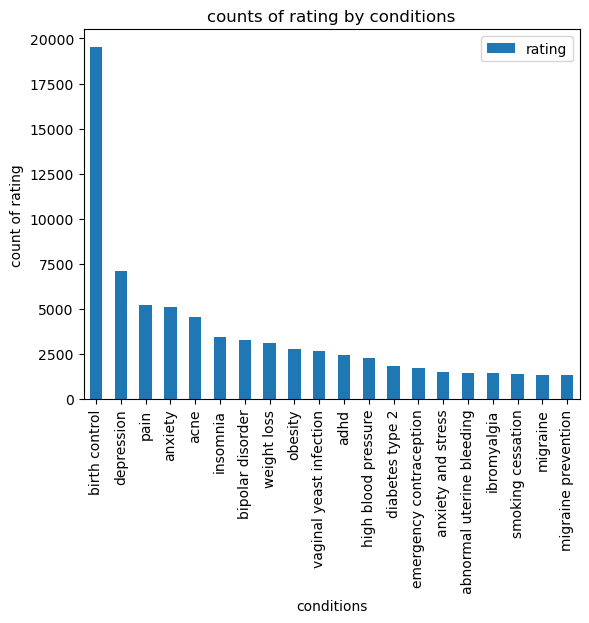

In [20]:
rating_by_condition = (
    df.groupby("condition")
    .agg({"rating": "count"})
    .sort_values(by="rating", ascending=False)
)
rating_by_condition = rating_by_condition.nlargest(20, "rating")
# visualize the results
plt.figure(figsize=(10, 6))
rating_by_condition.plot(kind="bar")
plt.title("counts of rating by conditions")
plt.xlabel("conditions")
plt.ylabel("count of rating")
plt.show()

The'birth control', 'depression','pain', 'anxiety' are the most treat conditons with over 5000 counts. 

for the top three conditions, what are the most review drugs for these condtions?

In [21]:
top_conditions = ['birth control','depression','pain']
mask = df[df['condition'].isin(top_conditions)]
drug_per_top_condition = mask.groupby(['condition','drugName']).size().reset_index(name="counts").sort_values(by =['condition','drugName'], ascending = [True,False])
drug_per_top_condition = drug_per_top_condition.groupby('condition').head(5)
drug_per_top_condition

,condition,drugName,counts
166,birth control,depo-subQ provera 104,1
165,birth control,Zovia 1 / 35,4
164,birth control,Zovia,23
163,birth control,Zenchent,1
162,birth control,Zarah,35
269,depression,Zyprexa,18
268,depression,Zoloft,206
267,depression,Xanax,30
266,depression,Wellbutrin XL,100
265,depression,Wellbutrin SR,35


different drugs are use to treat each condition.

In [22]:
drugName_list = df.drugName.unique().tolist()
print(len(drugName_list))


3168


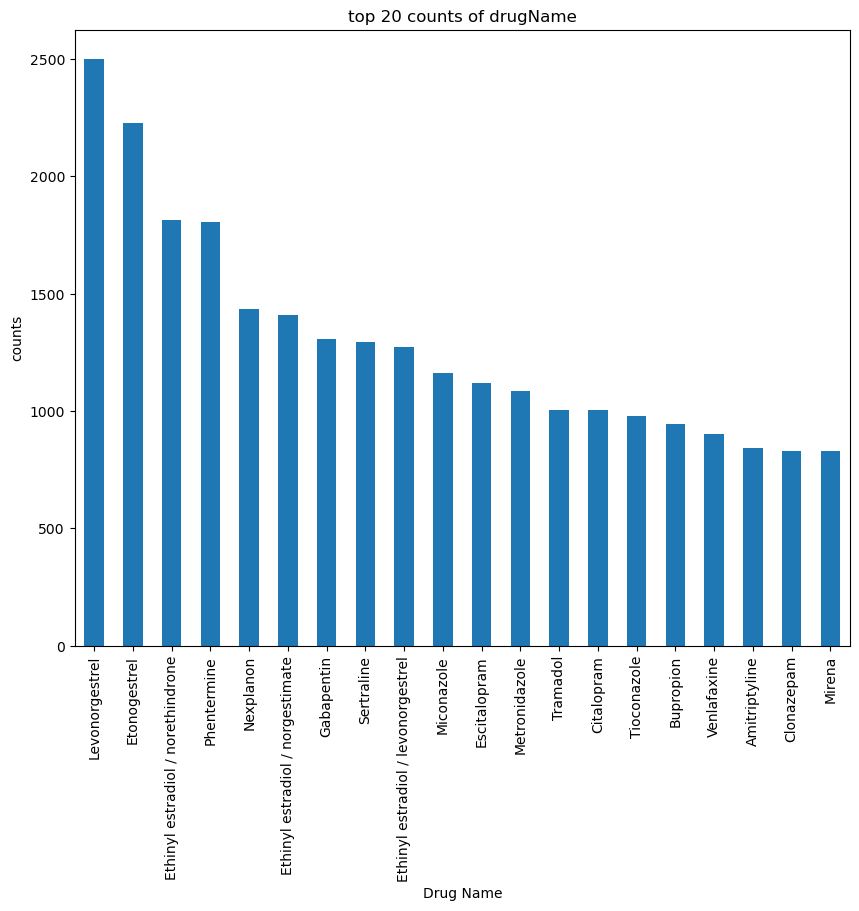

In [23]:
# check the most  count drugNme
plt.figure(figsize=(10, 8))
top_drugName = df["drugName"].value_counts(ascending=False).nlargest(20)
top_drugName.plot(kind="bar")
plt.title("top 20 counts of drugName")
plt.xlabel("Drug Name")
plt.ylabel("counts")
plt.show()

Among the top 10 birth control drug, Levonorgestrel and etonogestrel have over 2000/each reviews.

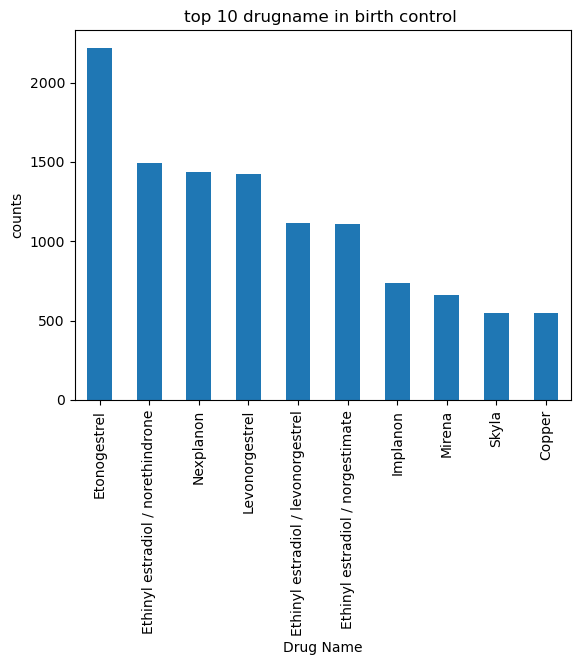

In [24]:
d1 = df[df["condition"] == "birth control"]["drugName"].value_counts()[0:10]
d1.plot(kind="bar")
plt.title("top 10 drugname in birth control ")
plt.xlabel("Drug Name")
plt.ylabel("counts")
plt.show()

what are the drugs with the highest rating?

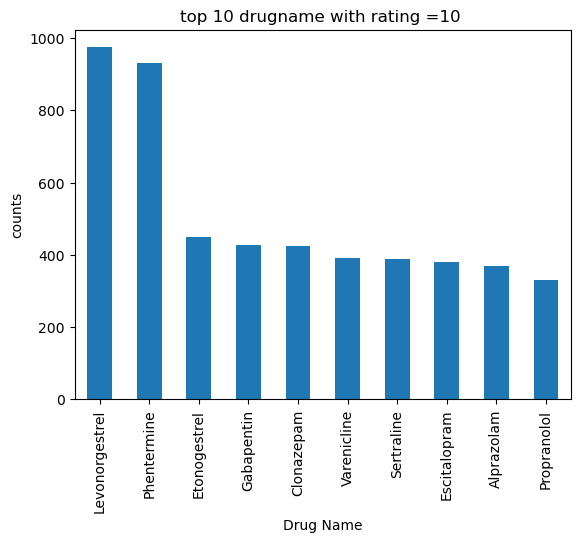

In [25]:
top_rating_drug = df[df["rating"] == 10]["drugName"].value_counts()
# plot the top 10 drug name with rating == 10
top_rating_drug[0:10].plot(kind="bar")
plt.title("top 10 drugname with rating =10 ")
plt.xlabel("Drug Name")
plt.ylabel("counts")
plt.show()

in the top 10 drugname with the highest rating 10, Levonorgestrel, phentermine, ethonogestrel, Gabapentin are used to treat the top conditions.

what are the drugs received the lowest rating?

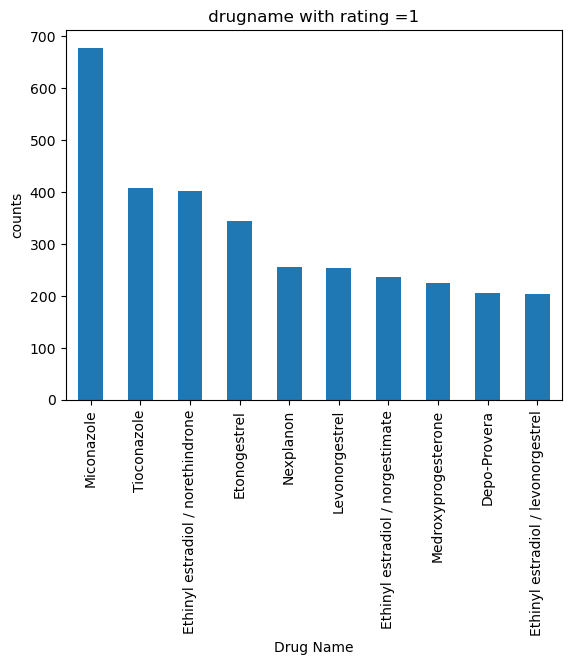

In [26]:
low_rating_drug = df[df["rating"] == 1]["drugName"].value_counts()
# plot the low 10 drug name with rating == 1
low_rating_drug[0:10].plot(kind="bar")
plt.title(" drugname with rating =1 ")
plt.xlabel("Drug Name")
plt.ylabel("counts")
plt.show()

it shows that for a same birth control drug 'Levonorgestre', the rating can be 1 to 10. 

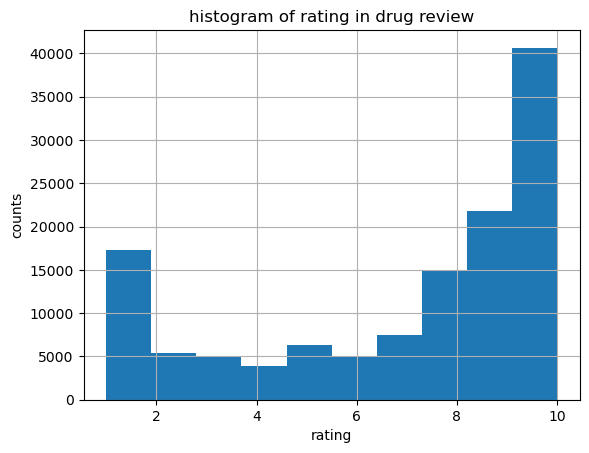

In [27]:
df["rating"].hist(bins=10)
plt.title("histogram of rating in drug review")
plt.xlabel("rating")
plt.ylabel("counts")
plt.show()

rating_category
positive    70.032085
neutral     17.057255
negative    12.910660
Name: proportion, dtype: float64


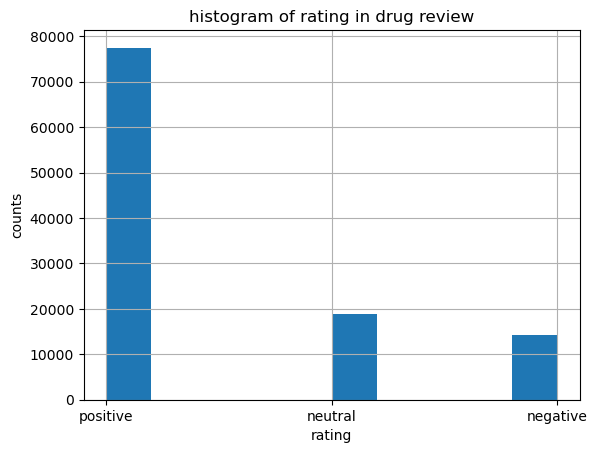

In [28]:
df["rating_category"] = pd.cut(
    df["rating"], bins=[1, 4, 7, 10], labels=["negative", "neutral", "positive"]
)
print(df["rating_category"].value_counts(normalize=True) * 100)

df["rating_category"].hist(bins=10)
plt.title("histogram of rating in drug review")
plt.xlabel("rating")
plt.ylabel("counts")
plt.show()

The rating is not eqully distributed, about 70% positive rating, only 17 % and 13% neutral and negative rating. The data is imbalanced.

visulaize the distribution of 'usefulCount'.

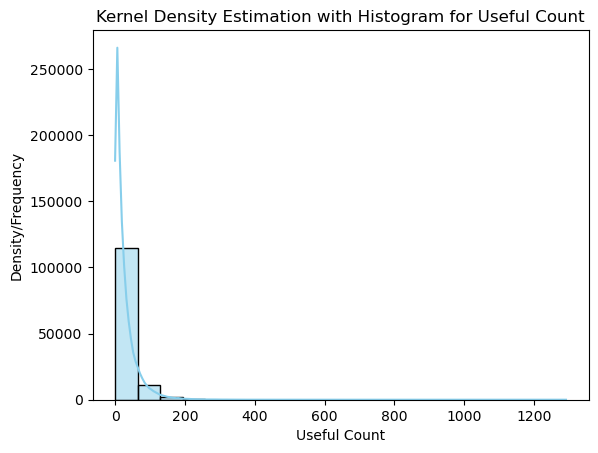

In [29]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
sns.histplot(df["usefulCount"], kde=True, bins=20, color="skyblue", edgecolor="black")
plt.title("Kernel Density Estimation with Histogram for Useful Count")
plt.xlabel("Useful Count")
plt.ylabel("Density/Frequency")

plt.show()

the distribution of usefulcount is skewed. the usefulCount is in range of 0-200.

what are the trends of reviews over years?

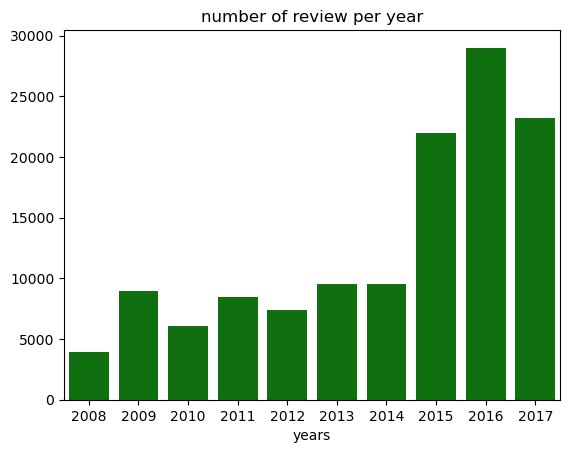

In [30]:
review_trend = df["date"].dt.year.value_counts()
review_trend.sort_index()
sns.barplot(x=review_trend.index, y=review_trend.values, color="green").set_title(
    "number of review per year"
)
plt.xlabel("years")
plt.show()

the number of reviews are increased over the years, in 2016 shows the most amounts of reviews. 

### Cleaning "review" and EDA

In [31]:
df[['review']].head()

,review
0,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"""
1,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."""
2,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."""
3,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"""
4,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin."""


To clean 'review', several steps will performed in a sequence:
1. remove_special_characters, especial html encorded one.
2. convert number to words
3. expand contraction
4. remove whitespace
5. remove stopwords
6. stem and lemmerlize word.

In [32]:
def remove_special_characters(text):
    text = text.lower()
    text = text.replace("&#039", "").replace("\n", "").replace("\r", "")
    text = text.replace(r"[^\w\d\s]", " ")
     # Replacing Two or more dots with one
    text = text.replace(r'\.{2,}', ' ')
    pattern = re.compile(r"[^a-zA-z0-9\s]+")
    cleaned_text = re.sub(pattern, "", str(text))
    cleaned_text = " ".join(word.strip() for word in text.split())
    return cleaned_text

In [33]:
# import inflect
p = inflect.engine()


# convert number into words
def convert_number(text):
    temp_text = text.split()
    new_text = []
    for word in temp_text:
        if word.isdigit():
            temp = p.number_to_words(word)
            new_text.append(temp)
        else:
            new_text.append(word)
    temp_text = " ".join(new_text)
    return temp_text

In [34]:
# import contractions
def expand_contractions(text):
    cleaned_text = contractions.fix(text)
    return cleaned_text

In [35]:
def remove_whitespace(text):
    return " ".join(text.split())

In [36]:
# import en_core_web_sm
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')
# from nltk.corpus import stopwords
# nlp= spacy.load('en_core_web_sm')
stop_words = set(stopwords.words("english"))


# import nltk
# nltk.download('punkt')
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return " ".join(filtered_text)

In [37]:
# apply the functions step by step to clean the review column
df["review_clean"] = df["review"].apply(remove_special_characters)
df["review_clean"] = df["review_clean"].apply(convert_number)
df["review_clean"] = df["review_clean"].apply(expand_contractions)
df["review_clean"] = df["review_clean"].apply(remove_whitespace)
df["review_clean"] = df["review_clean"].apply(remove_stopwords)

In [38]:
#stemming
Snow_ball = nltk.stem.SnowballStemmer("english")
df["review_clean"] = df["review_clean"].apply(
    lambda x: " ".join(Snow_ball.stem(word) for word in x.split())
)

In [39]:
# import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df["review_clean"] = df["review_clean"].apply(
    lambda x: " ".join(lemmatizer.lemmatize(word) for word in x.split())
)

In [40]:
#the "review" column is cleaned, so drop the orignal"reivew"column.
df= df.drop('review',axis = 1)
df.head()

,id,drugName,condition,rating,date,usefulCount,rating_category,review_clean
0,206461,Valsartan,left ventricular dysfunction,9,2012-05-20,27,positive,"`` side effect , take combin bystol five mg fish oil ''"
1,95260,Guanfacine,adhd,8,2010-04-27,192,positive,"`` son halfway fourth week intuniv . becam concern began last week , start take highest dose . two day , could hard get bed , cranki , slept near eight hour drive home school vacat ( unusu . ) call doctor monday morn said stick day . see school , get morn . last two day problem free . much agreeabl ever . le emot ( good thing ) , le cranki . rememb thing . overal behavior better . tri mani differ medic far effect . ''"
2,92703,Lybrel,birth control,5,2009-12-14,17,neutral,"`` use take anoth oral contracept , twenty-on pill cycl , happy- light period , max five day , side effect . contain hormon gestoden , avail u , switch lybrel , ingredi similar . pill end , start lybrel immedi , first day period , instruct said . period last two week . take second pack- two week . , third pack thing got even worse- third period last two week ; end third week- still daili brown discharge.th posit side ; side effect . idea period free tempt ... ala . ''"
3,138000,Ortho Evra,birth control,8,2015-11-03,10,positive,"`` first time use form birth control . ; glad went patch , eight month . first decreas libido subsid . downsid made period longer ( 5-6 day exact ) use period 3-4 day max also made cramp intens first two day period , never cramp use birth control . happi patch ''"
4,35696,Buprenorphine / naloxone,opiate dependence,9,2016-11-27,37,positive,"`` suboxon complet turn life around . feel healthier , ; excel job alway money pocket save account . none suboxon spent year abus oxycontin . paycheck alreadi spent time got start resort scheme steal fund addict . histori . ; readi stop , ; good chanc suboxon put path great life . found side-effect minim compar oxycontin . ; actual sleep better . slight constip . truli amaz . cost pale comparison spent oxycontin . ''"


Explore the count and length

In [41]:
#check the length of review
df['review_len'] = df['review_clean'].str.len()
# average sentence length
from nltk import tokenize
df['mean_sentence_len'] = df['review_clean'].map(lambda text: np.mean([len(sent) for sent in tokenize.sent_tokenize(text)]))


In [42]:
# number of words in each review
df["word_count"] = df["review_clean"].apply(lambda x: len(str(x).split()))
# average lenth of words
df["mean_word_len"] = df["review_clean"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()])
)
# unique word in each review
df["unique_word_count"] = df["review_clean"].apply(lambda x: len(set(str(x).split())))

In [43]:
df.head()

,id,drugName,condition,rating,date,usefulCount,rating_category,review_clean,review_len,mean_sentence_len,word_count,mean_word_len,unique_word_count
0,206461,Valsartan,left ventricular dysfunction,9,2012-05-20,27,positive,"`` side effect , take combin bystol five mg fish oil ''",55,55.000000,12,3.666667,12
1,95260,Guanfacine,adhd,8,2010-04-27,192,positive,"`` son halfway fourth week intuniv . becam concern began last week , start take highest dose . two day , could hard get bed , cranki , slept near eight hour drive home school vacat ( unusu . ) call doctor monday morn said stick day . see school , get morn . last two day problem free . much agreeabl ever . le emot ( good thing ) , le cranki . rememb thing . overal behavior better . tri mani differ medic far effect . ''",421,37.363636,89,3.741573,61
2,92703,Lybrel,birth control,5,2009-12-14,17,neutral,"`` use take anoth oral contracept , twenty-on pill cycl , happy- light period , max five day , side effect . contain hormon gestoden , avail u , switch lybrel , ingredi similar . pill end , start lybrel immedi , first day period , instruct said . period last two week . take second pack- two week . , third pack thing got even worse- third period last two week ; end third week- still daili brown discharge.th posit side ; side effect . idea period free tempt ... ala . ''",472,66.571429,94,4.031915,58
3,138000,Ortho Evra,birth control,8,2015-11-03,10,positive,"`` first time use form birth control . ; glad went patch , eight month . first decreas libido subsid . downsid made period longer ( 5-6 day exact ) use period 3-4 day max also made cramp intens first two day period , never cramp use birth control . happi patch ''",263,51.800000,53,3.981132,36
4,35696,Buprenorphine / naloxone,opiate dependence,9,2016-11-27,37,positive,"`` suboxon complet turn life around . feel healthier , ; excel job alway money pocket save account . none suboxon spent year abus oxycontin . paycheck alreadi spent time got start resort scheme steal fund addict . histori . ; readi stop , ; good chanc suboxon put path great life . found side-effect minim compar oxycontin . ; actual sleep better . slight constip . truli amaz . cost pale comparison spent oxycontin . ''",420,37.272727,77,4.467532,56


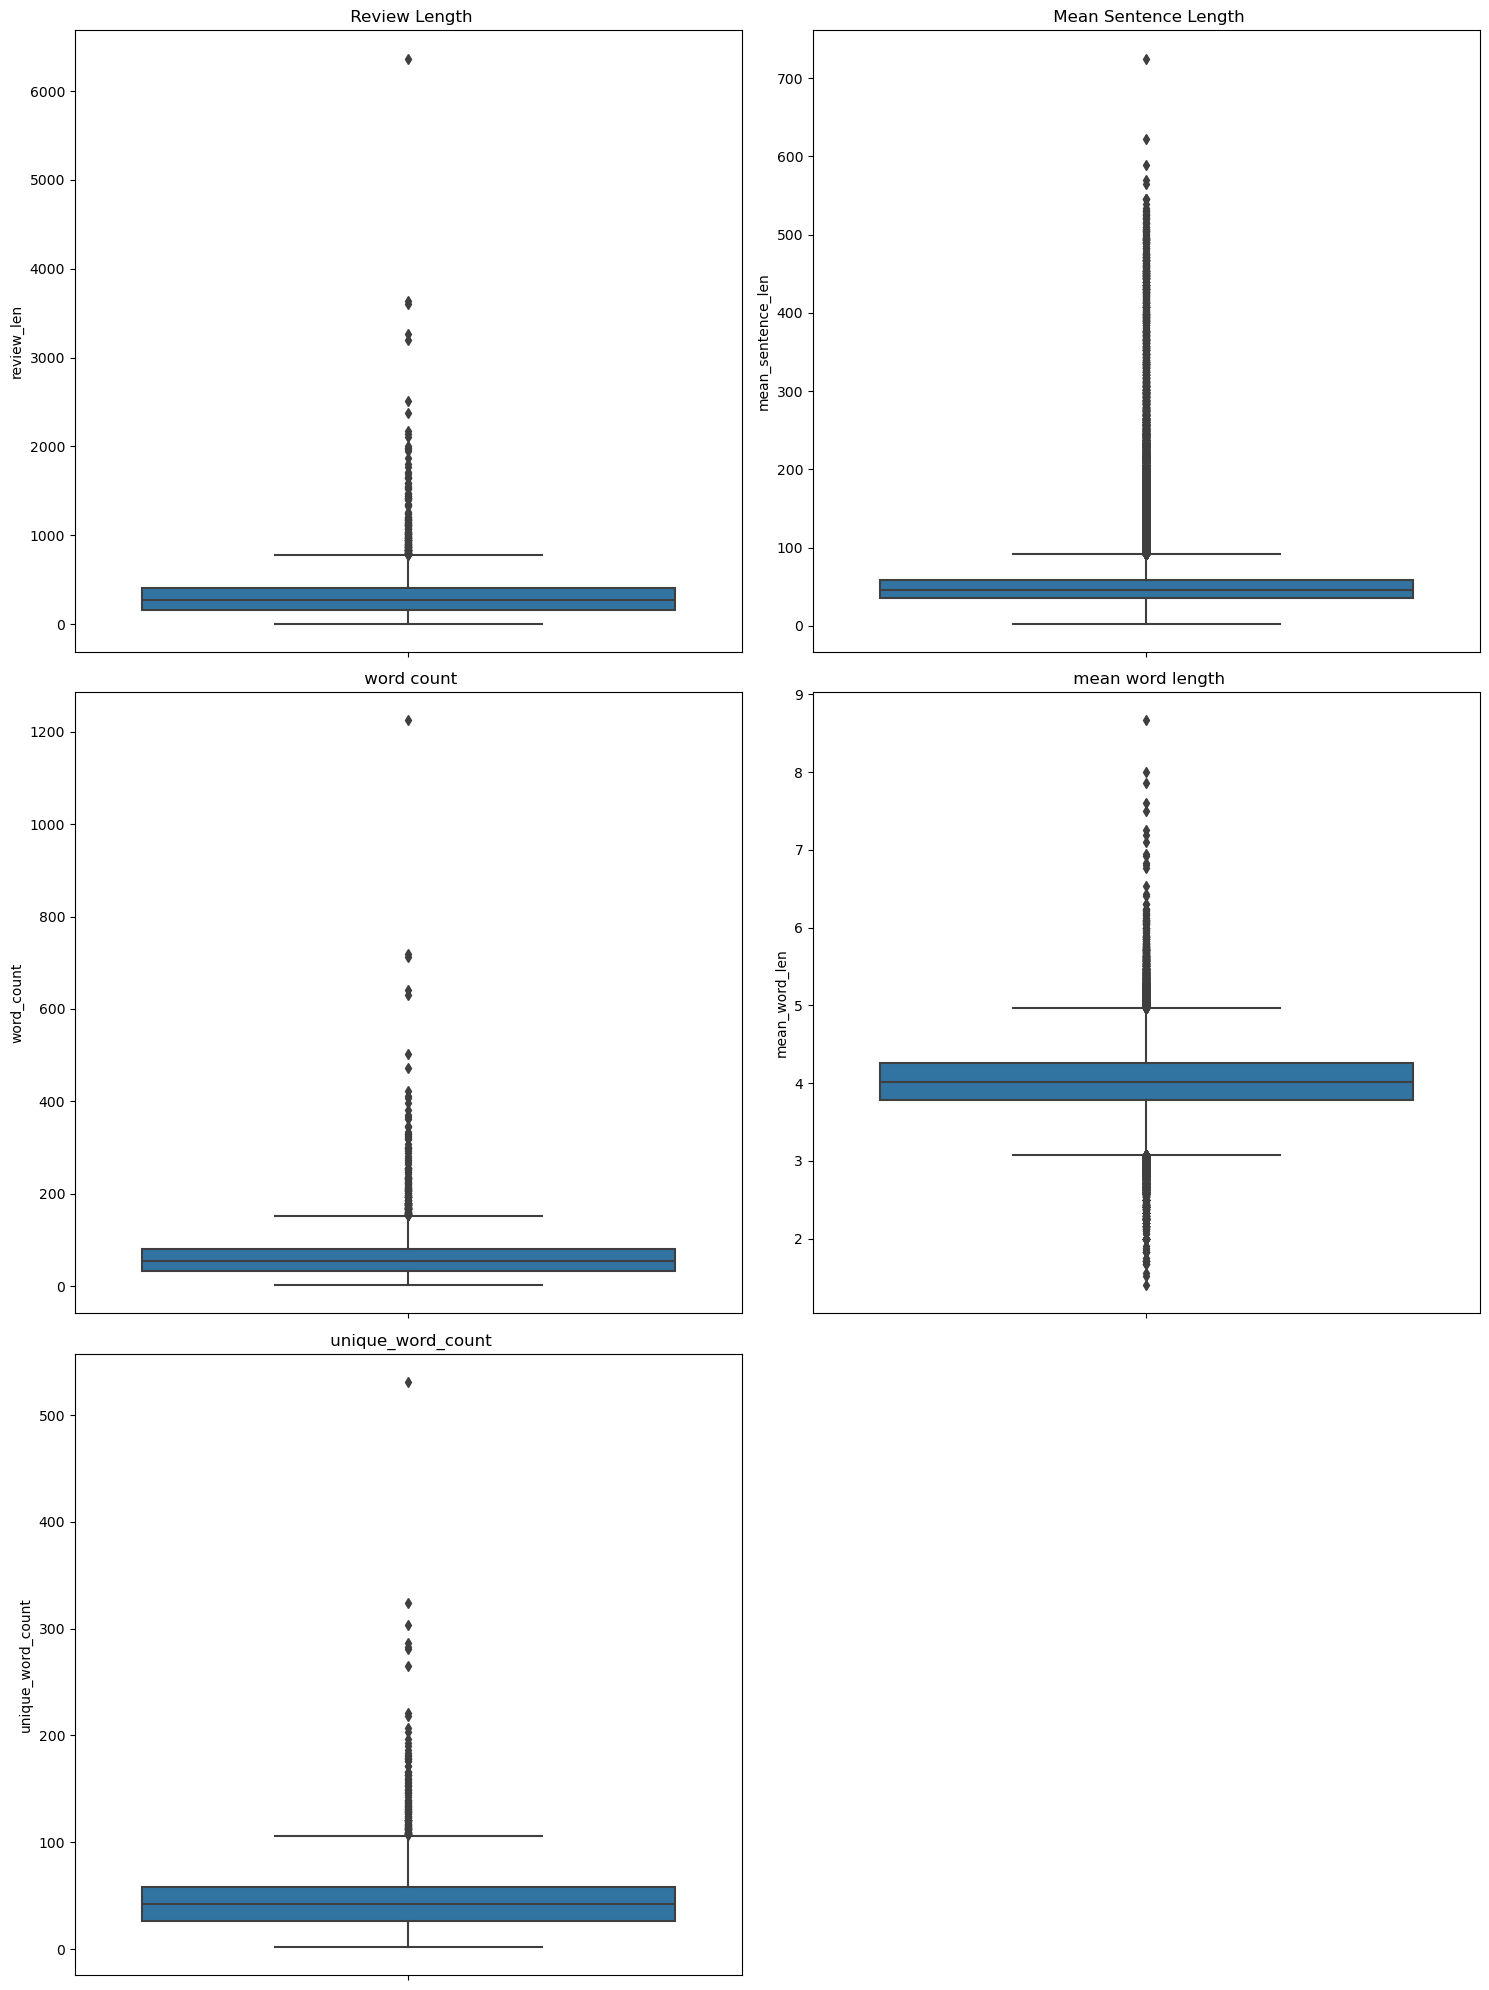

In [44]:
# visualize the results

fig, axes = plt.subplots(nrows =3, ncols =2, figsize=(15,20))

sns.boxplot(data = df, y= 'review_len', ax = axes[0,0])
axes[0,0].set_title(" Review Length")

sns.boxplot(data = df, y= 'mean_sentence_len', ax = axes[0,1])
axes[0,1].set_title(" Mean Sentence Length")

sns.boxplot(data = df, y= 'word_count', ax = axes[1,0])
axes[1,0].set_title(" word count")

sns.boxplot(data = df, y= 'mean_word_len', ax = axes[1,1])
axes[1,1].set_title(" mean word length")

sns.boxplot(data = df, y= 'unique_word_count', ax = axes[2,0])
axes[2,0].set_title(" unique_word_count")

# Remove empty subplot in the last row and column
fig.delaxes(axes[2, 1])
# adjust layout
fig.tight_layout()
plt.show()


for the new added 5 columns, each show some outliers.The review length medium is around 200, with the 1.5IQR below 1000. the medium of mean sentence length, medium word count, and unique word count are the range below 200 and 100, respectively. The medium length of word is 4.

what are the words in the highest and lowest ratings?

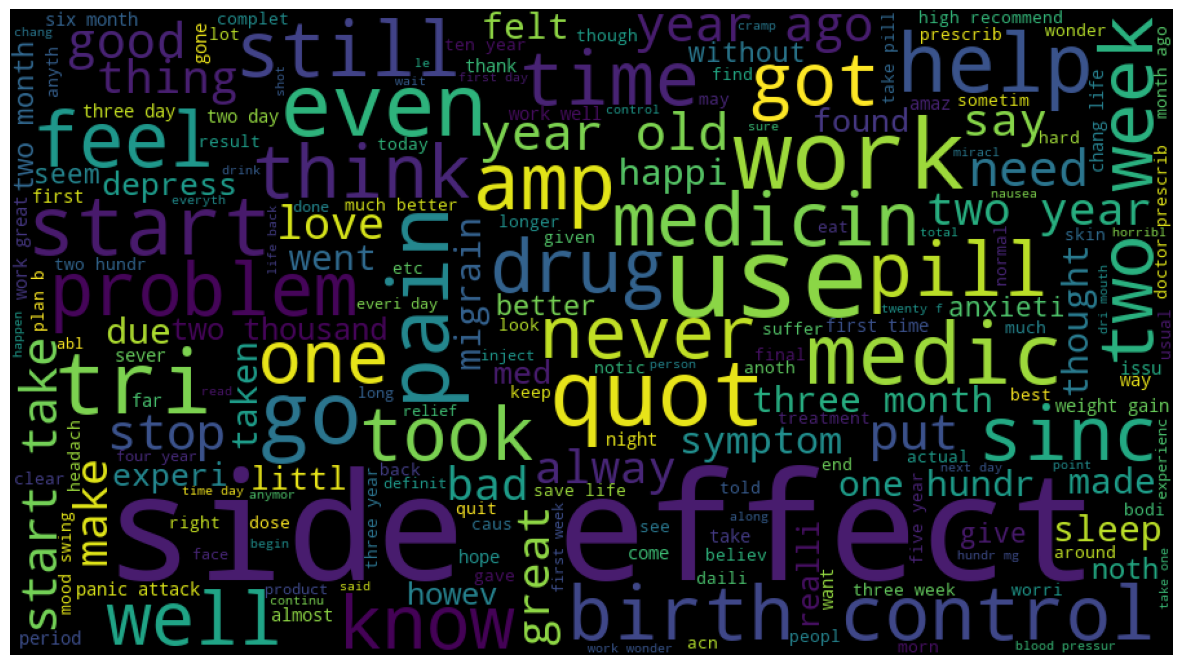

In [45]:
# words in top rating  =10
words_top_rating = df.loc[df.rating == 10, 'review_clean']
tx = (' '.join(words_top_rating))

wc = WordCloud(width = 900, height = 500).generate(tx)
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis('off');

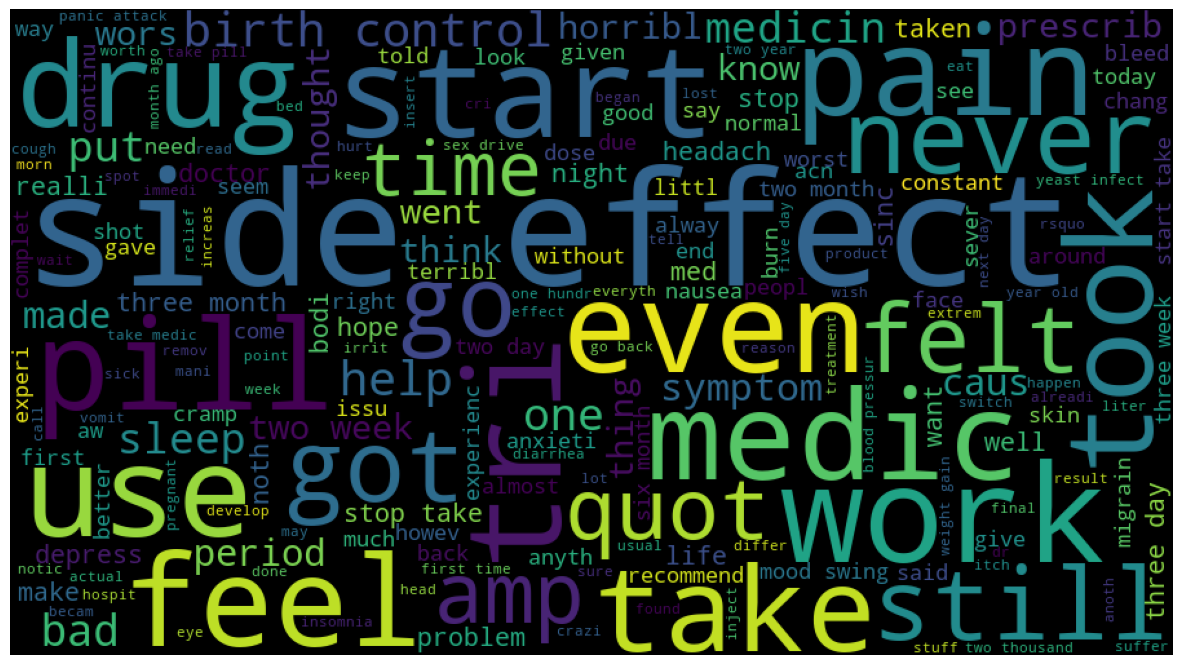

In [66]:
# words in lowest rating  =1
words_top_rating = df.loc[df.rating == 1, 'review_clean']
tx = (' '.join(words_top_rating))

wc = WordCloud(width = 900, height = 500).generate(tx)
plt.figure(figsize=(15, 10))
plt.imshow(wc)
plt.axis('off');

### Sentiment analysis

In [47]:
from textblob import TextBlob

In [48]:
# define a function to obtain sentiment values
def sentiment_score(text):
    blob = TextBlob(text)
    return blob.polarity

In [49]:
def sentiment_subjectivity(text):
    blob = TextBlob(text)
    return blob.subjectivity

In [50]:
# define a function to label the review in three sentiments: positive, negative and neutral.
def sentiment_label(text):
    blob = TextBlob(text)
    if blob.polarity > 0:
        return "positive"
    elif blob.polarity == 0:
        return "neutral"
    else:
        return "negative"

In [51]:
# add sentiment columns to the dataframe.

df["sentiment_subjectivity"] = df["review_clean"].apply(sentiment_subjectivity)
df["sentiment_score"] = df["review_clean"].apply(sentiment_score)
df["sentiment_label"] = df["review_clean"].apply(sentiment_label)

sentiment_label
positive    80775
negative    33685
neutral     13527
Name: count, dtype: int64


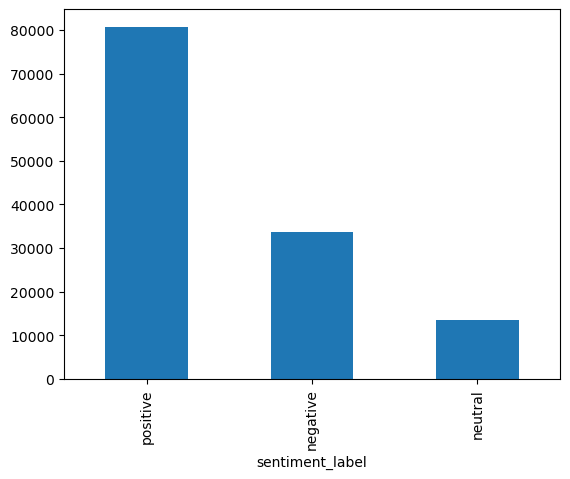

In [52]:
print(df["sentiment_label"].value_counts())
df["sentiment_label"].value_counts().plot(kind="bar")
plt.show()

More postive sentiment than negative one, the sentimentis are imbalanced.

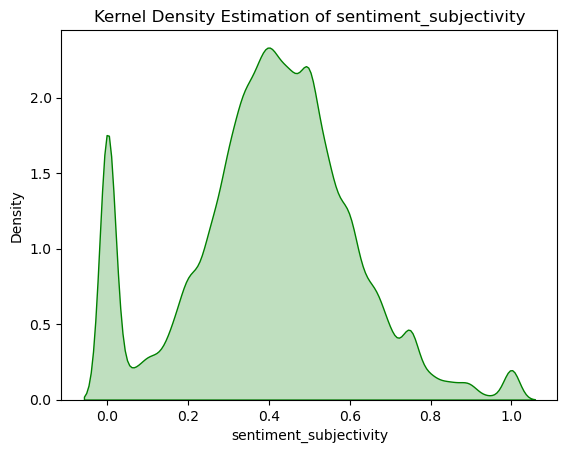

In [53]:
# check the sentiment_subjectivity distribution
sns.kdeplot(df["sentiment_subjectivity"], color="green", fill=True)
plt.title("Kernel Density Estimation of sentiment_subjectivity")
plt.xlabel("sentiment_subjectivity")
plt.ylabel("Density")

# Show the plot
plt.show()

Does the sentiment labels match with the rating?

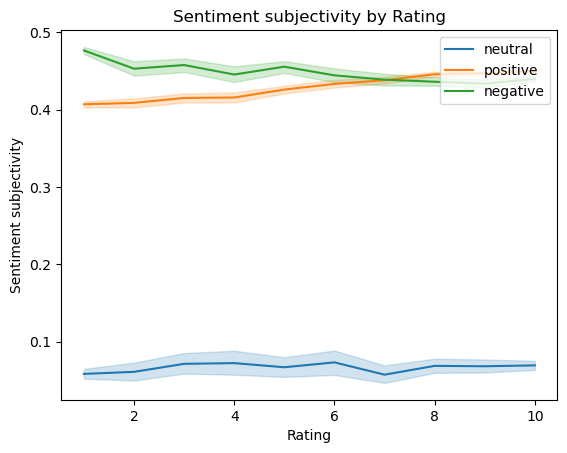

In [54]:
sns.lineplot(data=df, x="rating", y="sentiment_subjectivity", hue="sentiment_label")
plt.title("Sentiment subjectivity by Rating")
plt.xlabel("Rating")
plt.ylabel("Sentiment subjectivity")
# Move the legend to the upper-right corner
plt.legend(loc="upper right")
plt.show()

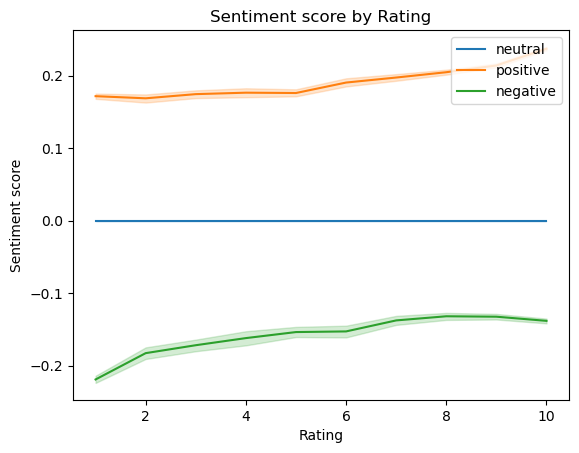

In [55]:
sns.lineplot(data=df, x="rating", y="sentiment_score", hue="sentiment_label")
plt.title("Sentiment score by Rating")
plt.xlabel("Rating")
plt.ylabel("Sentiment score")
# Move the legend to the upper-right corner
plt.legend(loc="upper right")
plt.show()

how the correlation amoung features?

In [56]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
# numerical_cols = ['rating','usefulCount','word_count','mean_word_len','sentiment_subjectivity','sentiment_score']
corr = df.corr(numeric_only = True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127987 entries, 0 to 215059
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      127987 non-null  int64         
 1   drugName                127987 non-null  object        
 2   condition               127987 non-null  object        
 3   rating                  127987 non-null  int32         
 4   date                    127987 non-null  datetime64[ns]
 5   usefulCount             127987 non-null  int64         
 6   rating_category         110645 non-null  category      
 7   review_clean            127987 non-null  object        
 8   review_len              127987 non-null  int64         
 9   mean_sentence_len       127987 non-null  float64       
 10  word_count              127987 non-null  int64         
 11  mean_word_len           127987 non-null  float64       
 12  unique_word_count       127987 non-

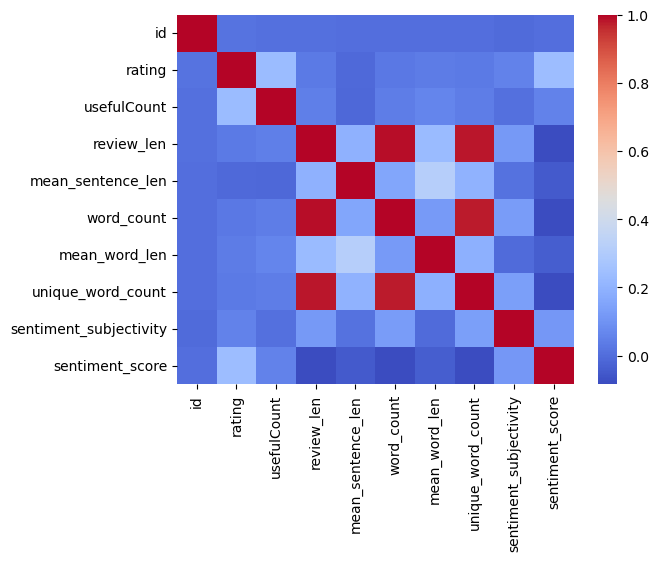

In [58]:
sns.heatmap(corr,cmap = 'coolwarm')
plt.show()

The plot shows for each type of sentiments, there are widespread of rating. Below give the way to check the genuine rating of reviews.

In [59]:
df["genuine_positive"] = np.where(
    (df["rating_category"] == "positive")
    & (df["sentiment_label"] == "positive")
    & (df["sentiment_subjectivity"] <= 0.3),
    1,
    0,
)

In [60]:
df["genuine_negative"] = np.where(
    (df["rating_category"] == "negative")
    & (df["sentiment_label"] == "negative")
    & (df["sentiment_subjectivity"] <= 0.3),
    1,
    0,
)

In [61]:
df["genuine_neutral"] = np.where(
    (df["rating_category"] == "neutral")
    & (df["sentiment_label"] == "neutral")
    & (df["sentiment_subjectivity"] <= 0.3),
    1,
    0,
)



In [62]:
df.head()

,id,drugName,condition,rating,date,usefulCount,rating_category,review_clean,review_len,mean_sentence_len,word_count,mean_word_len,unique_word_count,sentiment_subjectivity,sentiment_score,sentiment_label,genuine_positive,genuine_negative,genuine_neutral
0,206461,Valsartan,left ventricular dysfunction,9,2012-05-20,27,positive,"`` side effect , take combin bystol five mg fish oil ''",55,55.000000,12,3.666667,12,0.000000,0.000000,neutral,0,0,0
1,95260,Guanfacine,adhd,8,2010-04-27,192,positive,"`` son halfway fourth week intuniv . becam concern began last week , start take highest dose . two day , could hard get bed , cranki , slept near eight hour drive home school vacat ( unusu . ) call doctor monday morn said stick day . see school , get morn . last two day problem free . much agreeabl ever . le emot ( good thing ) , le cranki . rememb thing . overal behavior better . tri mani differ medic far effect . ''",421,37.363636,89,3.741573,61,0.417500,0.170833,positive,0,0,0
2,92703,Lybrel,birth control,5,2009-12-14,17,neutral,"`` use take anoth oral contracept , twenty-on pill cycl , happy- light period , max five day , side effect . contain hormon gestoden , avail u , switch lybrel , ingredi similar . pill end , start lybrel immedi , first day period , instruct said . period last two week . take second pack- two week . , third pack thing got even worse- third period last two week ; end third week- still daili brown discharge.th posit side ; side effect . idea period free tempt ... ala . ''",472,66.571429,94,4.031915,58,0.330556,0.120833,positive,0,0,0
3,138000,Ortho Evra,birth control,8,2015-11-03,10,positive,"`` first time use form birth control . ; glad went patch , eight month . first decreas libido subsid . downsid made period longer ( 5-6 day exact ) use period 3-4 day max also made cramp intens first two day period , never cramp use birth control . happi patch ''",263,51.800000,53,3.981132,36,0.450000,0.300000,positive,0,0,0
4,35696,Buprenorphine / naloxone,opiate dependence,9,2016-11-27,37,positive,"`` suboxon complet turn life around . feel healthier , ; excel job alway money pocket save account . none suboxon spent year abus oxycontin . paycheck alreadi spent time got start resort scheme steal fund addict . histori . ; readi stop , ; good chanc suboxon put path great life . found side-effect minim compar oxycontin . ; actual sleep better . slight constip . truli amaz . cost pale comparison spent oxycontin . ''",420,37.272727,77,4.467532,56,0.288519,0.147037,positive,1,0,0


# save data 

In [63]:
df.to_csv("../data/processed/drug_review_clean.csv", index=False)

# Summary

Initially, the two raw .tsv datasets were loaded and concatenated into a single dataframe, resulting in a shape of (215063, 7).

1194 records lacked information in the "condition" category, constituting a missing ratio of 0.56%. These records were removed from the dataset.

birth control, depression, pain are the top review conditions. More than 1000 conditions with comments "users found it is useful" were  treated as noise and dropped from the dataset.

The "condition" column underwent a cleansing process to rectify typos and incorrect spellings, utilizing the .apply(dictionary) method.

Within the "review" subset, over 85,000 duplications were identified. These duplications solely displayed variations in drug names for the same condition. Consequently, only the original records were retained.

Visualization was employed to depict the top-rated conditions and the leading review drugs for birth control.

The "review" column underwent a comprehensive cleaning process involving multiple functions: removing special characters, eliminating whitespace, eradicating stopwords, expanding contractions, stemming, and lemmatization.

New columns, including "rating_category," 'word_count,' 'mean_word_len,' 'unique_word_count,' 'genuine_positive,' 'genuine_negative,' 'genuine_neutral,' 'sentiment_subjectivity,' 'sentiment_score,' and 'sentiment_label,' were introduced to enhance the dataset's features.
